<a href="https://colab.research.google.com/github/fhswf/campus_tag/blob/master/dijkstra-woeste.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Der beste Weg von Woeste-Gymnasium zur Fachhochschule Südwestfalen 

In [ ]:
!pip install osmnx

In [2]:
import networkx as nx
import osmnx as ox
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
ox.config(use_cache=True, log_console=True)
ox.__version__

'1.0.1'

## Lade das Straßennetz

Wir werden gleich das Straßennetz von Openstreetmap laden und darstellen. Da die Darstellung nicht so schön aussehen wird wie auf einer richtigen Landkarte,
hier zum Vergleich der entsprechende Kartenausschnitt auf Google Maps:

![](https://github.com/fhswf/campus_tag/blob/master/google_map.png?raw=1)

Wir laden nun das reine Straßennetz (`network_type='drive'`) – Flüsse, Eisenbahnlinien etc. lassen wir weg. Die Funktion zum Laden des Netzwerks sorgt auch automatisch dafür, dass die Straßen am Rand "abgeschnitten" werden.

In [3]:
NORD = 51.40
SUED = 51.36
WEST = 7.652
OST  = 7.786

# Koordinaten des Woeste-Gymnasiums
START = (51.385042387866754, 7.757903727377975)

# Koordinaten der Fachhochschule Südwestfalen, Iserlohn
ZIEL = (51.36835, 7.68485)

In [4]:
G = ox.graph.graph_from_bbox(NORD, SUED, OST, WEST, network_type='drive', truncate_by_edge=True)

## Start- und Zielknoten bestimmen

Nun suchen wir den Start- und Zielknoten im Netz. Dazu nehmen wir die jeweiligen Koordinaten und suchen den nächsten Knoten im Straßennetz

In [5]:
start = ox.get_nearest_node(G, START)
ziel = ox.get_nearest_node(G, ZIEL)

## Reisezeiten berechnen

Damit wir den besten Weg bestimmen können, müssen wir festlegen, wie schnell man auf den einzelnen Strecken fahren kann, und anschließend für jede Kante die 
Fahrzeit berechnen.

In [6]:
speeds = { 'motorway': 140, 'primary': 100, 'secondary': 40, 'residential': 20 }

G = ox.speed.add_edge_speeds(G, hwy_speeds=speeds, fallback=20, precision=1)
G = ox.speed.add_edge_travel_times(G, precision=1)   

## Darstellung des Netzes

Das Zeichnen einer Karte ist ziemlich kompliziert. Wir legen hier nur ein paar Regeln fest, wie einzelne Straßen dargestellt werden sollen.

In [7]:
colors = { 'primary': 'orange', 'motorway': 'red', 'motorway_link': 'violet', 'secondary': 'orange', 'tertiary': 'green', 'residential': 'gray'}
widths = { 'primary': 3, 'motorway': 4}
          
nc = [ 'red' if n == start or n == ziel else 'white' for n in G.nodes() ]
ns = [ 90 if n == start or n == ziel else 0 for n in G.nodes() ]
ec = [ colors[data['highway']] if type(data['highway']) == str and data['highway'] in colors else 'black' for u, v, data in G.edges(data=True) ]
lw = [ widths[data['highway']] if type(data['highway']) == str and data['highway'] in widths else 1 for u, v, data in G.edges(data=True) ]


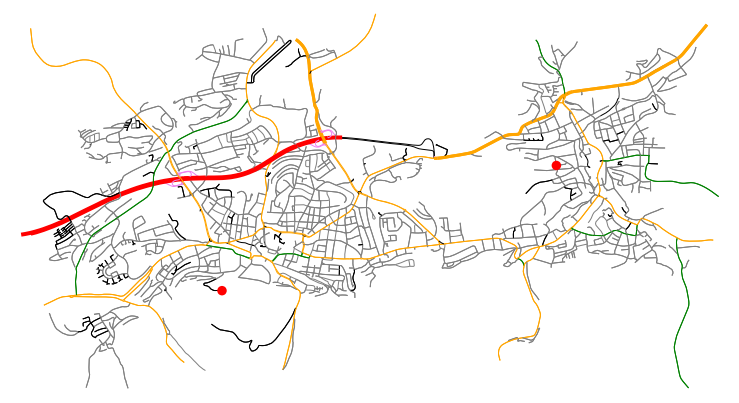

Das Netz hat 1842 Knoten und 4372 Kanten


In [8]:
ox.plot_graph(G, figsize=(13, 19), bgcolor='white', node_color = nc, edge_color=ec, node_size=ns, edge_linewidth=lw)

print(f"Das Netz hat {len(G.nodes())} Knoten und {len(G.edges())} Kanten")

## Berechnung des besten Weges mit dem Dijkstra-Algorithmus

Wir berechnen nun den besten Weg mit dem in der Präsentation vorgestellten Dijkstra-Algorithmus. Dabei können wir noch mitgeben, welche Eigenschaft einer 
Kante die *Kosten* bestimmt. Mit `travel_time` können wir die **schnellste Route** bestimmen, mit `length` die **kürzeste Route**.

Im Dijkstra-Algorithmus brauchen wir immer den Punkt mit den niedrigsten Kosten, den wir noch nicht 'abgearbeitet' haben. 
Dazu verwenden wir eine `PriorityQueue`, die das auch mit vielen Punkten sehr effizient erledigt.

Intern verwendet die `PriorityQueue` einen sogenannten *binary Heap* (engl. *heap* für *Haufen*). Ein *binary Heap* ist ein Baum, in dem die Kinder jedes Knotens mindestens so groß sind wie der Elternknoten. Damit lässt sich das Minimum (= Wurzelelement) in konstanter Zeit finden. Das Entnehmen des Minimums und das Einfügen eines Wertes benötigen logarithmische Laufzeit.
Der Baum wird dabei normalerweise wie folgt in einem Array abgelegt:
![](https://github.com/fhswf/campus_tag/blob/master/Min-heap.svg?raw=1)

Das Elternelement des Elements $i$ befindet sich jeweils an Position $(i-1)/2$; das linke Kind an Position $2i + 1$ und das rechte Kind an Position $2i+2$.

In [9]:
import heapq

class PriorityQueue:
    """Implemetierung einer PriorityQueue mit Hilfe von heapq.
    heapq verwaltet einen Heap, d.h. eine Liste von numerischen Werten mit schnellem Zugriff auf das 
    kleinste Element."""
    
    def __init__(self):
        self._queue = []
        self._len = 0

    def __len__(self):
        return self._len
    
    def push(self, item, priority):
        heapq.heappush(self._queue, (priority, item))
        self._len += 1
        
    def pop(self):
        """Gibt das Element mit der kleinsten Priorität zurück."""
        self._len -= 1
        return heapq.heappop(self._queue)[-1]

In [10]:
def dijkstra(G, p, key='travel_time'):
    """Der Dijkstra-Algorithmus bestimmt den Abstand aller Punkte von einem Startpunkt aus.
    Rückgabe ist ein dictionary, das zu jedem Punkt den Abstand und den Vorgänger enthält.
    Der Parameter key gibt an, welches Attribut als 'Länge' verwendet wird. 
    """
    
    dist = dict()
    pred = dict()
    pq = PriorityQueue()
    
    # Initialisierung: Der Startpunkt hat Abstand 0 und keinen Vorgänger
    pq.push(p, 0)
    dist[p] = 0
    pred[p] = None
    
    # Wähle den Punkt mit dem kleinsten Abstand und aktualisiere von ihm aus die Abstände
    while len(pq) > 0:
        q = pq.pop()
        for r in nx.neighbors(G, q):
            cost = G[q][r][0][key]
            
            # Prüfe, ob wir einen neuen bzw. besseren Weg nach r gefunden haben
            if (r not in dist) or (dist[q] + cost < dist[r]):
                dist[r] = dist[q] + cost
                pred[r] = q
                pq.push(r, dist[r])
    
    return (dist, pred)

In [11]:
def cost(G, route, key='length'):
    _cost = 0
    for i in range(len(route) - 1):
        p, q = route[i], route[i+1]
        _cost += G[p][q][0][key]
    return _cost

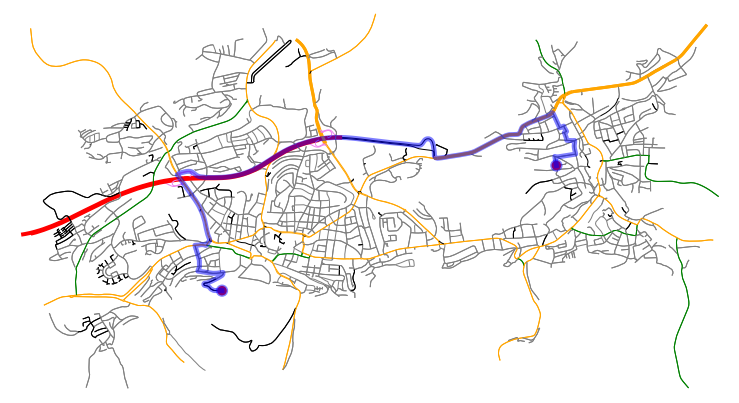

Schnellster Weg vom Bergstadtgymnasium zur Fachhochschule: 12.5 Minuten, 10.3 km


In [12]:
dist, pred = dijkstra(G, start, key='travel_time')
route = []
q = ziel
while q is not None:
    route.insert(0, q)
    q = pred[q]
ox.plot_graph_route(G, route, figsize=(13,19), route_color='blue', route_linewidth=5, orig_dest_size=150, 
                    bgcolor='white', node_color=nc, edge_color=ec, node_size=ns, edge_linewidth=lw)
print(f"Schnellster Weg vom Bergstadtgymnasium zur Fachhochschule: {dist[ziel]/60:.1f} Minuten, {cost(G, route, 'length')/1000:.1f} km")


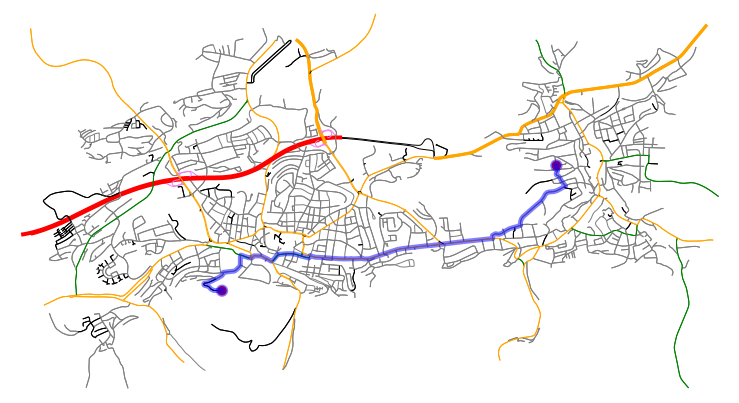

Kürzester Weg vom Bergstadtgymnasium zur Fachhochschule: 6.8 km, 13.0 Minuten


In [13]:
dist, pred = dijkstra(G, start, key='length')
route = []
q = ziel
while q is not None:
    route.insert(0, q)
    q = pred[q]
    
ox.plot_graph_route(G, route, figsize=(13,19), route_color='blue', route_linewidth=5, orig_dest_size=150, 
                    bgcolor='white', node_color=nc, edge_color=ec, node_size=ns, edge_linewidth=lw)
print(f"Kürzester Weg vom Bergstadtgymnasium zur Fachhochschule: {dist[ziel]/1000:.1f} km, {cost(G, route, 'travel_time')/60:.1f} Minuten")